In [ ]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Modeling, selection, and evaluation
from fastai.text import *
#from fastai.text import learner, transform, language_model_learner
#from fastai.text import TextClasDataBunch
#from fastai.text import TextList

#from MyLSTM import AWD_LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Read file into dataframe
file_dir = '/content/gdrive/My Drive/APS360 Project/'
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv(file_dir + "training.1600000.processed.noemoticon - Copy.csv")
df = df.reindex(np.random.permutation(df.index))  
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
454169,0,2070524973,Sun Jun 07 17:50:59 PDT 2009,NO_QUERY,LilMichou,"while brushing my teeth, i somehow managed to fling my toothbrush into the toilet","while brushing my teeth, i somehow managed to fling my toothbrush into the toilet"
817610,4,1551808078,Sat Apr 18 10:01:34 PDT 2009,NO_QUERY,dollyboox3,@tarabearra YEAHH buhahahah . miissedd uuu like i love spongebob xD u rememberr . lmfaoo. iloveyoutodiie.,YEAHH buhahahah . miissedd uuu like i love spongebob xD u rememberr . lmfaoo. iloveyoutodiie.
473173,0,2177010667,Mon Jun 15 05:15:27 PDT 2009,NO_QUERY,nounour,I am so sad. That's unfair. I so want to see @jonasbrothers &amp; @ddlovato live in TUNISIA.,I am so sad. That's unfair. I so want to see &amp; live in TUNISIA.
764112,0,2298709430,Tue Jun 23 12:00:59 PDT 2009,NO_QUERY,reemer,passing York - typed up notes from meeting with senior officers of engagement at Arts Council. Holiday leave over need a holiday.,passing York - typed up notes from meeting with senior officers of engagement at Arts Council. Holiday leave over need a holiday.
166788,0,1961449612,Fri May 29 09:31:13 PDT 2009,NO_QUERY,jasminepotts,@nattymsmith awww she's laavly ;) I had to come in but I've got a stunning wee tan (l) ;) yourself?,awww she's laavly ;) I had to come in but I've got a stunning wee tan (l) ;) yourself?


In [ ]:
df_processed = df.drop(df.columns[2:6], axis=1)
df_processed.head()

,0,1467810369,"http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
454169,0,2070524973,"while brushing my teeth, i somehow managed to fling my toothbrush into the toilet"
817610,4,1551808078,YEAHH buhahahah . miissedd uuu like i love spongebob xD u rememberr . lmfaoo. iloveyoutodiie.
473173,0,2177010667,I am so sad. That's unfair. I so want to see &amp; live in TUNISIA.
764112,0,2298709430,passing York - typed up notes from meeting with senior officers of engagement at Arts Council. Holiday leave over need a holiday.
166788,0,1961449612,awww she's laavly ;) I had to come in but I've got a stunning wee tan (l) ;) yourself?


In [ ]:
df_processed['tweet_length'] = len(df_processed.columns[2])

In [ ]:
df_processed.columns = ['sentiment','tweet_id', 'text', 'tweet_length']

In [ ]:
df_clean = df_processed.dropna()
df_clean.columns = ['sentiment','tweet_id', 'text', 'tweet_length']
df_clean.head()
df_clean.shape[0]
df_clean.fillna(0)

,sentiment,tweet_id,text,tweet_length
454169,0,2070524973,"while brushing my teeth, i somehow managed to fling my toothbrush into the toilet",102
817610,4,1551808078,YEAHH buhahahah . miissedd uuu like i love spongebob xD u rememberr . lmfaoo. iloveyoutodiie.,102
473173,0,2177010667,I am so sad. That's unfair. I so want to see &amp; live in TUNISIA.,102
764112,0,2298709430,passing York - typed up notes from meeting with senior officers of engagement at Arts Council. Holiday leave over need a holiday.,102
166788,0,1961449612,awww she's laavly ;) I had to come in but I've got a stunning wee tan (l) ;) yourself?,102
...,...,...,...,...
115398,0,1827075084,i'm still in bed and i have to work today and write a paper after work,102
216404,0,1975700724,Battery dieing... Will probably have to go back to the bb soon I need to invest in a new battery! #PCPC,102
559989,0,2205095006,Your emails are not working it seems x,102
191886,0,1969736250,Forgot that I had also made a smelly mess when I dropped and shattered a pickle jar.,102


In [ ]:
test_percentage = 0.0005
#df_clean.sort_index(inplace=True)#Increase subset
cutoff = int(test_percentage * df_clean.shape[0])
df_clean[['sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df_clean[['sentiment', 'text']][cutoff:cutoff+50000].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df_clean[['text']][cutoff:cutoff+50000].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

In [ ]:
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
xxbos xxup up xxup early xxup but xxup no xxup church xxup im xxup going 2 xxup have xxup church n xxup me xxup apt xxup just xxup as xxup soon xxup as i xxup go xxup by xxup job xxup b4 i xxup curse xxup her xxup out ! xxup lol ! xxup she xxup woke xxup me xxup up !,0
xxbos xxmaj firefly xxup xxunk ðºð ° ðºð ° xxup xxunk xxunk xxunk ° xxup xxunk ° xxunk ? xxunk xxunk ° xxup xxunk xxup xxunk ° xxunk ° . xxup xxunk ° xxup xxunk ° xxunk » xxunk xxunk xxup xxunk ° xxunk xxunk xxunk ° xxup xxunk ? xxunk ° xxup xxunk ° xxup xxunk xxup xxunk xxunk ? xxunk,0
xxbos xxup hate xxup hate xxup hate admin - my admin file labels read & ' xxmaj boring xxmaj stuff 1 & ' & ' xxup bs 2 & ' & ' xxmaj stuff 2 try & & avoid & ' etc . ! ! ! xxmaj xxunk * xxunk arms & & stomps foot *,0
xxbos xxup it xxup matters xxup most xxup tomorrow xxup but xxup still xxup sa xxrep 4 d xxup this xxup is xxup one xxup reason xxup to xxup dive xxup into xxup the xxup poison xxup of xxup my xxup choice xxup lol xxup francis xxup xxunk xxup wine xxup omg xxup yummm ! !,0
xxbos xxmaj had a xxmaj xxunk xxmaj night xxmaj with xxmaj xxunk ... xxmaj all xxmaj ruined xxmaj by xxmaj the xxmaj face xxmaj by xxmaj my xxmaj backk xxmaj started xxmaj xxunk xxmaj up xx xxmaj ohh xxmaj well xxmaj love xxmaj youu xxmaj xxunk xx 8 xxmaj days xxmaj xxunk,0


In [ ]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'i']

In [ ]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos aww me too ! ! ! we miss you .
xxbos homework
xxbos xxmaj falling asleep fast . xxmaj headache


In [ ]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[  2 342  31  66  11  11  11  69  89  20]
[  2 554]
[   2    5 1026  516  692   10    5  365]


In [ ]:
bs = 48
seed = 333

In [ ]:
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [ ]:
data_lm.show_batch()

idx,text
0,"contacts xxbos ow , i rolled of ma parents bed yesterday and landed on ma hip and i now have a huge xxunk n i cnt touch it cause it hurts heaps xxbos xxmaj very sad .. xxmaj my xxunk falling out of love with me xxbos xxunk - xxrep 4 ? ? ? ? xxbos xxmaj oh sugar , that 's not nice xxbos xxmaj my cinema . xxmaj"
1,"can play the xxunk card ... xxbos so , uhm , answer : xxmaj probably , but not many xxunk exist apparently , except maybe in xxmaj psychology . xxmaj the woo have taken over xxbos xxmaj only 1 hour 50 minutes left of work xxmaj better get back to it then xxbos xxmaj had a very fun game night with xxmaj we played xxmaj xxunk xxmaj quest and xxmaj"
2,"gettin my xxunk xxbos xxmaj at east xxunk chino stop eating ... lmao they have some hugh xxunk ... lmao no club soda ! xxbos i wished i could play too ... xxbos xxunk ... okay , i will pay no attention to the man behind the curtain xxbos a classic sunday ... xxmaj good xxunk ... xxmaj then fried chicken ! xxmaj life is good ! xxbos oh n"
3,"xxup hot coffee xxbos xxmaj it 's not as much as i appreciate the information . xxmaj thanks ! xxbos i must get ready to go out , other xxunk mate is taking me for a walk and talk xxrep 4 . dreading it xxbos you became like xxunk now .. part of our hearts are going with you ! ! do nt xxunk xxrep 6 e xxrep 6 !"
4,anymore . i 'll have to download everything again . xxbos i love you xxbos i am preparing for the launch of the xxmaj wall of 100 xxmaj faces . xxmaj it is going well . xxmaj but i did very little this weekend and am now behind xxbos xxmaj thank you xxmaj bill for the well wishes xxmaj packing was a xxunk and one of the wheels on my


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
raw_output = AWD_LSTM
print(raw_output)

<class 'fastai.text.models.awd_lstm.AWD_LSTM'>


In [ ]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


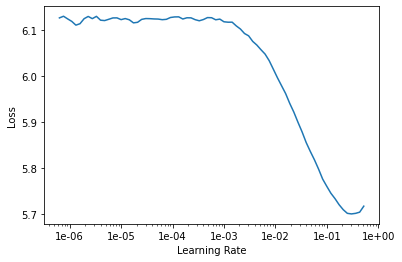

In [ ]:
learn.recorder.plot(skip_end=15)


In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.480843,4.246226,0.228571,29:06


In [ ]:
learn.save('fit_head')


In [ ]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(9, 1e-3, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.183802,4.005543,0.300000,45:29
1,4.070733,3.930424,0.285714,44:21
2,3.962897,3.896124,0.285714,45:32
3,3.761619,3.773818,0.300000,45:44
4,3.524674,3.773977,0.328571,45:25
5,3.285469,3.755852,0.328571,45:31
6,3.064705,3.800383,0.342857,45:18
7,2.924395,3.842550,0.328571,45:14
8,2.845730,3.849326,0.328571,45:11


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


text,target
xxbos xxmaj firefly xxup xxunk xxunk ° xxunk ° xxup xxunk xxunk xxunk ° xxup xxunk ° xxunk ? xxunk xxunk ° xxup xxunk xxup xxunk ° xxunk ° . xxup xxunk ° xxup xxunk ° xxunk xxunk xxunk xxunk xxup xxunk ° xxunk xxunk xxunk ° xxup xxunk ? xxunk ° xxup xxunk ° xxup xxunk xxup xxunk xxunk ? xxunk,0
xxbos xxmaj home at last . xxmaj now bed ! xxmaj thanks to my xxup awesome moving crew ! xxmaj you guys rock ! xxmaj missin ' some xxup xxunk . xxmaj lots of xxunk ' up to do in xxmaj east xxmaj xxunk !,0
xxbos is callin it a night . xxmaj too bad my xxmaj twitter crush was n't on tonight . [ xxup xxunk xxup lose xxup it ] [ xxup lol ] xxmaj oh xxmaj well ... better luck tomorrow ... right ? ! g'night !,0
xxbos i am so lame xxrep 4 . xxmaj it 's 8 pm and i 'm in bed xxrep 4 . how did this happen ? ? xxmaj did n't i have a life at one point ? ? i need chocolate xxrep 4 .,0
xxbos i xxup will xxup no xxup longer xxup be xxup on xxup twitter i xxup made a xxup bet xxup and i xxup lost xxup so xxup the xxup bet xxup was xxup if xxup lost i xxup delete xxup my xxup twitter,0


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (45000 items)
x: TextList
xxbos is sad i fell asleep and missed something ... but now i m watchin the tony awards ! ! !,xxbos you re extremely lucky you re not home ! i felt like curling up into a ball , but i did nt . i went out to get ice & & got rained on,xxbos yes over the 3 wireless network . xxmaj but i lost all my contacts,xxbos ow , i rolled of ma parents bed yesterday and landed on ma hip and i now have a huge xxunk n i cnt touch it cause it hurts heaps,xxbos xxmaj very sad .. xxmaj my xxunk falling out of love with me
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (5000 items)
x: TextList
xxbos xxmaj xxunk house ... missing,xxbos xxup rip xxunk and xxunk great female xxunk r far and between nowadays ...,xxbos xxmaj is in saturday school right now,xxbos i am lost . xxmaj please help me find a good home .,xxbos xxmaj missed u today
y: CategoryList
0,0,0,0,0
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEnc

In [ ]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


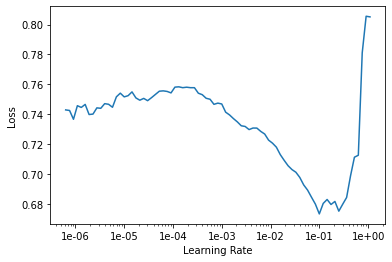

In [ ]:
learn.recorder.plot()


In [ ]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.481021,0.435656,0.803000,17:52


In [ ]:
test_df = pd.read_csv("/content/gdrive/My Drive/APS360 Project/testdata_old.csv", encoding="utf-8")

In [ ]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print(test_df)

     sentiment  ... pred_sentiment
0    4          ...  0            
1    4          ...  0            
2    4          ...  4            
3    4          ...  0            
4    4          ...  4            
..  ..          ... ..            
98   4          ...  0            
99   4          ...  0            
100  0          ...  0            
101  4          ...  0            
102  4          ...  0            

[103 rows x 3 columns]


In [ ]:
learn.data.classes #Two possible predictions

[0, 4]

In [ ]:
learn.predict('who Created  just To humiliate Me') #Interpretation: tensor(0) means selected 0 = negative sentiment, 80% chance of being negative, 20% of being positive

(Category tensor(0), tensor(0), tensor([0.5631, 0.4369]))

In [ ]:
learn.predict('love you great thanks happy') #Interpretation: tensor(1) means selected 4 = positive sentiment, 13.65% chance of being negative, 86.35% of being positive

(Category tensor(1), tensor(1), tensor([0.0521, 0.9479]))

In [ ]:
test_df['pred_sentiment']= test_df['pred_sentiment'].astype(str).astype(int)

In [ ]:
print(test_df['pred_sentiment'])

0      0
1      4
2      4
3      0
4      0
      ..
98     0
99     0
100    0
101    0
102    0
Name: pred_sentiment, Length: 103, dtype: int64


In [ ]:
print("Test Accuracy: ", accuracy_score(test_df['sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.4854368932038835


In [ ]:
test_df1 = pd.read_csv("/content/gdrive/My Drive/APS360 Project/test2data.csv", encoding="utf-8")

In [ ]:
test_clas = (TextList.from_csv('.', 'Tweets_filtered_test.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
test_clas.save('test_clas.pkl')
test_clas.show_batch()


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


text,target
xxbos oo ? xxunk ? xxunk ? ? d ? ? xxunk s ? ? ? u xxrep 6 ? xxrep 4 ? ? ' p ? ? ? o ? p ? ? ? ? no ? ? xxunk ? ? xxunk ? xxunk ? u ? ? o ? ? o ? xxrep 4 ? ? oo ? o ? xxrep 4 ? o ? ? xxunk ?,4
xxbos xxunk -- > > who the hell are you ? ? ! ! how xxunk you say ' xxunk # % you ' to me . g xxrep 4 r xxrep 4 ! xxunk xxunk xxunk xxunk ... http : / / plurk.com / p / xxunk,0
"xxbos xxmaj have you seen the & ' xxmaj xxunk xxmaj xxunk & ' in xxmaj twitter ? xxmaj mine says : & ' xxmaj eat xxmaj xxunk , xxup sis , xxmaj xxunk , xxmaj david xxmaj xxunk ... & ' xxmaj haha , so cool !",4
xxbos xxup oh xxup no xxrep 5 ! xxmaj is everything ok xxrep 4 ! i did nt know you were go to xxmaj greek xxmaj picnic xxrep 4 ! xxup xxunk i m xxunk ! ! ! xxup lol xxmaj hope you had fun tho !,0
"xxbos i just got invited to the xxmaj metal xxmaj hammer awards in xxmaj london . xxmaj it 's on a xxmaj monday night . xxmaj gah , not xxunk to make that . xxmaj how un - metal . / w \ / w \ !",0


In [ ]:
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")

In [ ]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))

In [ ]:
test_df['pred_sentiment']= test_df['pred_sentiment'].astype(str).astype(int)

In [ ]:
print("Test Accuracy: ", accuracy_score(test_df['sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8164435946462715
